# PCLab#3-Group08-Jing Wang,Yixin He, Yunqi Cao
###4-5 hours


In [2]:
pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 287 kB 25.1 MB/s 
     |████████████████████████████████| 106 kB 18.8 MB/s 


In [3]:
#pip install contractions # remove  contracted words like aren't 
import pandas as pd 
import numpy as np
import spacy
import gensim
import nltk
import re
import string
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
import contractions
import sys
from wordcloud import WordCloud 

In [4]:
nlp=spacy.load('en_core_web_sm',disable=['parser', 'ner'])

In [7]:
data=pd.read_csv('Data_PCLab3_Twitter_Stock_Sentiment.csv')

In [ ]:
data.head()

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1


In [14]:
#Describe the data: this dataset contains tweets of financial sentiments of tweeter users, the total number of tweets is 5791.
print ("Numbers of tweets   : " ,data.shape[0]) # total number of tweets 
print ("\nNumbers of columns  : " ,data.shape[1]) 
print ("Columns : \n" ,data.columns.tolist())
print ("\nMissing tweets :  ", data.isnull().sum().values.sum())

#Control if in our dataset we have duplicated tweets
N_duplicated_ID=data['Text'].duplicated().sum()
print('Number of duplicated Tweets: ', N_duplicated_ID)


Numbers of tweets   :  5791

Numbers of columns  :  2
Columns : 
 ['Text', 'Sentiment']

Missing tweets :   0
Number of duplicated Tweets:  0


In [15]:
#We removed the punctuations and extra spaces between words to compute the distribution of # of words per tweets, because if they are present we would have a biased
#distribution, increasing the number of words per tweets. 
#We sobtituted the contracted from of verbs
def remove_punctuation(text):
    return re.sub('[%s]' % re.escape(string.punctuation), '' , text)

def remove_extra_spaces(text):
    return re.sub(' +', ' ', text)

def remove_contraction(text):
    tokens = text.split()
    return ' '.join([contractions.fix(word) for word in tokens])
        

In [16]:
#ensure all tweets are string
data.Text = data.Text.apply(str) 

In [17]:
#apply the function
data.Text=data.Text.apply(lambda x:remove_punctuation(x))
data.Text=data.Text.apply(lambda x: remove_extra_spaces(x))
data.Text=data.Text.apply(lambda x: remove_contraction(x))

In [18]:
data

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user AAP MOVIE 55 return for the FEAGEED indic...,1
2,user Id be afraid to short AMZN they are looki...,1
3,MNTA Over 1200,1
4,OI Over 2137,1
...,...,...
5786,Industry body CII said discoms are likely to s...,0
5787,Gold prices slip below Rs 46000 as investors b...,0
5788,Workers at Bajaj Auto have agreed to a 10 wage...,1
5789,Sharemarket LIVE Sensex off day’s high up 600 ...,1


In [19]:
#Splitting the words in each tweet 
data['Tokens']=data.Text.apply(lambda x: x.split(' '))
#Compute the number of words in each tweet 
data['n_words']=data.Tokens.apply(lambda x: len(x))

Text(0.5, 1.0, 'Distribution of number of words')

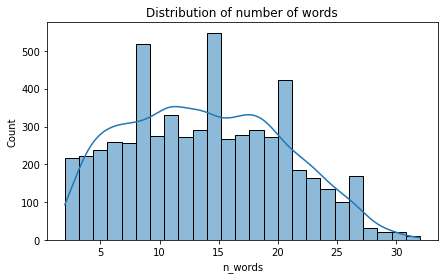

In [22]:
#plot distribution of number of words per tweet without punctuations and extra spaces
fig=plt.figure(figsize=(7,4))
sns.histplot(data['n_words'],kde=True)
plt.title('Distribution of number of words')

In [23]:
#Computing the average sentiment: # of postive and negative sentiment 
print('Posive sentiment:',data.Sentiment.value_counts()[1]) 
print('Negative sentiment:',data.Sentiment.value_counts()[0])
print('Average positive sentiment:',round(data.Sentiment.mean(),4))

Posive sentiment: 3685
Negative sentiment: 2106
Average positive sentiment: 0.6363


Text(0.5, 1.0, 'Average Sentiment')

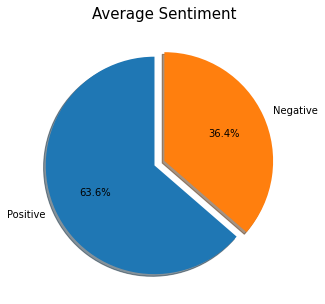

In [25]:
#Plot of the average sentiment
fig=plt.figure(figsize=(8,5))
plt.pie([data.Sentiment.value_counts()[1],data.Sentiment.value_counts()[0]],explode=(0.1,0),labels=['Positive','Negative'],autopct='%1.1f%%',shadow=True, startangle=90)
plt.title('Average Sentiment',fontdict={'fontsize':15})

## Task #2 : Cleaning and visualization

In [26]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [27]:
stopwords_ = set(stopwords.words('english'))

In [28]:
# Keep only alphabetic characters
def remove_general(text):
    return re.sub(r'[^A-Za-z_-]'," ",text)
# Considering that in Twitter users use emojis, we removed them 
def remove_emojis(text): 
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  
        u"\U0001F300-\U0001F5FF"  
        u"\U0001F680-\U0001F6FF"  
        u"\U0001F1E0-\U0001F1FF"  
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)
#We removed all the words with less than 3 characters, except the elements in the 'short_tickers' since they are stocks
short_tickers = {'A','T','C','D','F','J','K','L','O','V','MO','BK','BA','BR','CE','CF','CB','CI','KO','CL','ED','DE','DG','DD','EW','EA','EL','ES','RE','FB','FE','IT','GD','GE','GM','GL','GS','HD','IR','IP','KR','LH','LW','MA','MU','MS','NI','PH','PM','PG','RL','RF','SO','TT','UA','VZ','WM','WU','WY'}
def remove_shortwords(text):
    tokens = text.split()
    return ' '.join([word for word in tokens if (len(word)>2) or (word in short_tickers)])

# We decided to lemmatize instead of stemming, to convert the word to its meaningful base form
def lemmatize(text):
    return ' '.join([token.lemma_ for token in nlp(text)])

#Remove stopwords
stopwords_ = set(stopwords.words('english'))
def remove_stopwords(text):
    tokens = text.split()
    return ' '.join([word for word in tokens if word not in stopwords_])

#Remove URL
def remove_url(text):
  return re.sub(r'http\S+', '', text)

# Removing the twitter usernames from tweet string
def remove_username(text):  
  return re.sub(r'@\w+', ' ', text)
 

In [29]:
#apply function defined above
data['Text_clean'] = data['Text']
data.Text_clean=data.Text_clean.apply(lambda x: remove_general(x))
data.Text_clean=data.Text_clean.apply(lambda x: remove_emojis(x))
data.Text_clean=data.Text_clean.apply(lambda x: remove_shortwords(x))
data.Text_clean=data.Text_clean.str.lower()
data.Text_clean=data.Text_clean.apply(lambda x: lemmatize(x))
data.Text_clean=data.Text_clean.apply(lambda x: remove_stopwords(x))
data.Text_clean=data.Text_clean.apply(lambda x: remove_url(x))
data.Text_clean=data.Text_clean.apply(lambda x: remove_username(x))
data.drop(['n_words','Tokens'],axis=1,inplace=True)
data

,Text,Sentiment,Text_clean
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,kicker watchlist xide tit soq pnk cpw bpz trad...
1,user AAP MOVIE 55 return for the FEAGEED indic...,1,user aap movie return feageed indicator trade ...
2,user Id be afraid to short AMZN they are looki...,1,user afraid short amzn look like nearmonopoly ...
3,MNTA Over 1200,1,mnta
4,OI Over 2137,1,
...,...,...,...
5786,Industry body CII said discoms are likely to s...,0,industry body cii say discom likely suffer net...
5787,Gold prices slip below Rs 46000 as investors b...,0,gold price slip investor book profit amid coro...
5788,Workers at Bajaj Auto have agreed to a 10 wage...,1,worker bajaj auto agree wage cut period april ...
5789,Sharemarket LIVE Sensex off day’s high up 600 ...,1,sharemarket live sensex day high point nifty t...


In [ ]:
# Divide positive sentiment with negative sentiment 
positive_tweets=data[data['Sentiment']==1]
all_positive_tweets=' '.join(tweet for tweet in positive_tweets.Text_clean)
negative_tweets=data[data['Sentiment']==0]
all_negative_tweets=' '.join(tweet for tweet in negative_tweets.Text_clean)

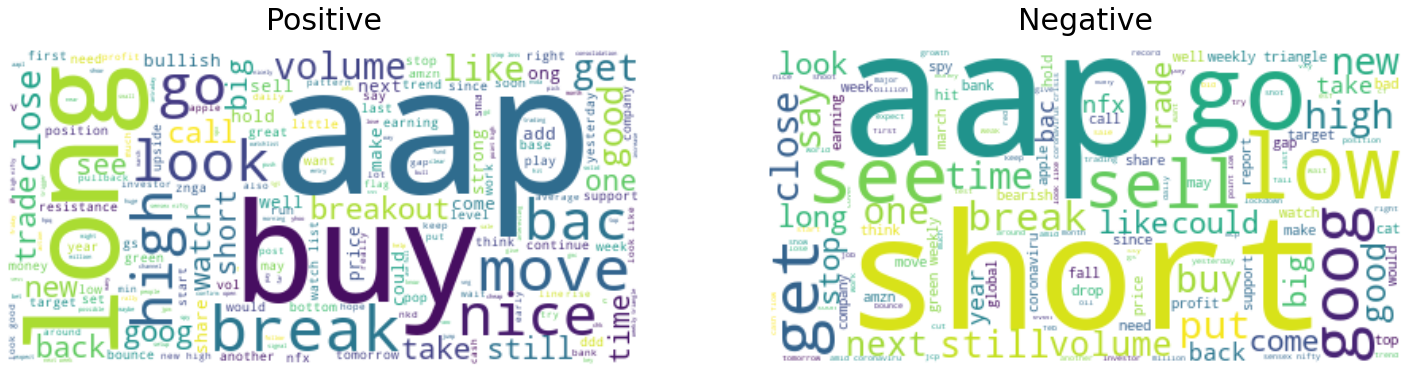

In [ ]:
#Plot the wordcloud
custom_stopwords=['stock','market','user','today','day',] # eliminating words we consider not important
fig,axs=plt.subplots(1,2,figsize=(25,15))
ax=axs[0]
word_cloud1=WordCloud(background_color='white',stopwords=custom_stopwords).generate(all_positive_tweets)
ax.imshow(word_cloud1,interpolation='bilinear')
ax.set_title('Positive',fontdict={'fontsize':30},pad=20)
ax.axis('off')
ax=axs[1]
word_cloud2=WordCloud(background_color='white',stopwords=custom_stopwords).generate(all_negative_tweets)
ax.imshow(word_cloud2,interpolation='bilinear')
ax.set_title('Negative',fontdict={'fontsize':30},pad=20)
ax.axis('off')
plt.show()

Comment: As we are conducting the sentiment analysis, we  can observe that the words appeared in the positive sentiment tweets are most related to some positive words such as "buy","good", "nice", "long","high", instead in the most negative sentiment tweets we can find words such as "short", "sell", "low".
This is why when breaking news comes in stock prices will react (price discovery). Investors will process the new information and decide how stock prices will be affected. And you'll see price movements following the news.
APP has a high media attention in both positive and negative tweets, while in the negative tweets GOOG is the most mentioned.

In [30]:
# Extra: we wanted to see if there any relevant n_grams, instead of single words.
#define n_grams(=2) to plot again the wordcloud 
def generate_N_grams(text,ngram=1): # generates list of bigram
  words=[word for word in text.split(" ") if word not in set(stopwords.words('english'))]  
  temp=zip(*[words[i:] for i in range(0,ngram)])
  ans=[' '.join(ngram) for ngram in temp]
  return ans

In [31]:
data['n_grams']=data.Text_clean.apply(lambda x: generate_N_grams(x,2))

In [32]:
data

,Text,Sentiment,Text_clean,n_grams
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,kicker watchlist xide tit soq pnk cpw bpz trad...,"[kicker watchlist, watchlist xide, xide tit, t..."
1,user AAP MOVIE 55 return for the FEAGEED indic...,1,user aap movie return feageed indicator trade ...,"[user aap, aap movie, movie return, return fea..."
2,user Id be afraid to short AMZN they are looki...,1,user afraid short amzn look like nearmonopoly ...,"[user afraid, afraid short, short amzn, amzn l..."
3,MNTA Over 1200,1,mnta,[]
4,OI Over 2137,1,,[]
...,...,...,...,...
5786,Industry body CII said discoms are likely to s...,0,industry body cii say discom likely suffer net...,"[industry body, body cii, cii say, say discom,..."
5787,Gold prices slip below Rs 46000 as investors b...,0,gold price slip investor book profit amid coro...,"[gold price, price slip, slip investor, invest..."
5788,Workers at Bajaj Auto have agreed to a 10 wage...,1,worker bajaj auto agree wage cut period april ...,"[worker bajaj, bajaj auto, auto agree, agree w..."
5789,Sharemarket LIVE Sensex off day’s high up 600 ...,1,sharemarket live sensex day high point nifty t...,"[sharemarket live, live sensex, sensex day, da..."


In [33]:
#Define the bigram in the tweets with a positive sentiment
positive_tweets_n_grams=data[data['Sentiment']==1]
all_positive_tweets_n_grams=[]
for i in range(len(positive_tweets_n_grams.n_grams)):
  all_positive_tweets_n_grams+=data.n_grams[i]

In [34]:
#Define the bigram in the tweets with a negative sentiment
negative_tweets_n_grams=data[data['Sentiment']==0]
all_negative_tweets_n_grams=[]
for i in range(len(negative_tweets_n_grams.n_grams)):
  all_negative_tweets_n_grams+=data.n_grams[i]

In [36]:
#join the bigram with '_', e.g kicker watchlist to kicker_watchlist
string=','.join(all_positive_tweets_n_grams)
string=string.replace(' ','_')
string2=','.join(all_negative_tweets_n_grams)
string2=string.replace(' ','_')

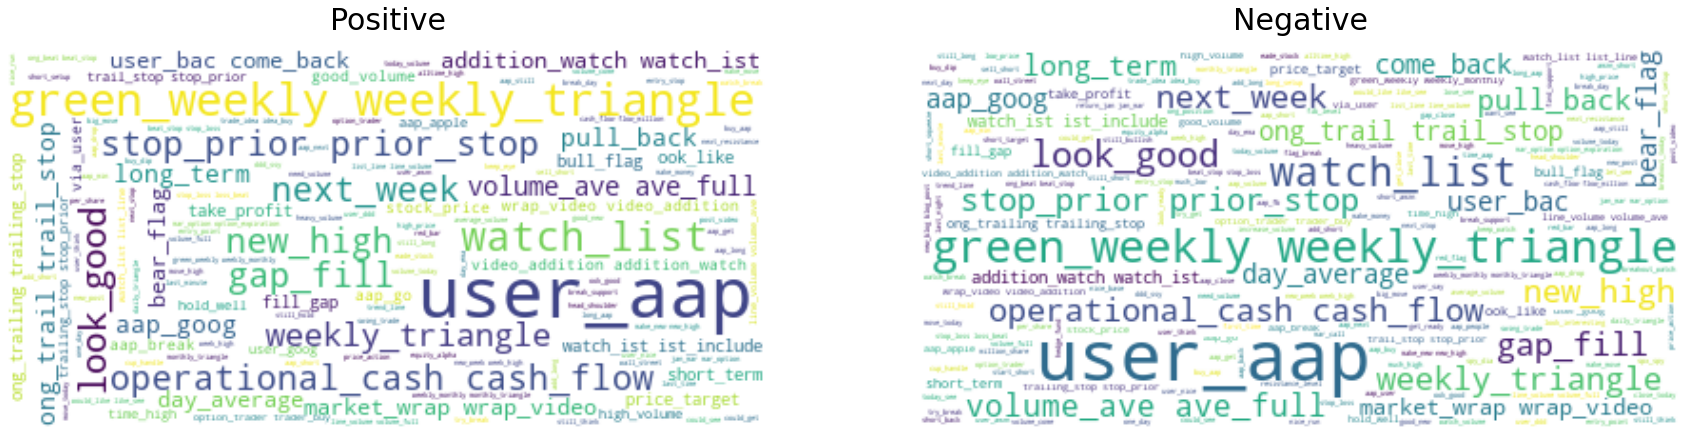

In [37]:
#Plot the wordcloud
# Comment: It's interesting the fact that in the two_grams what we observe the most is referred also to the user_aap (Advance Auto Parts).
# It probabily due to the fact that in the dataset there are a lot of arguments about this company, demonstrating a high media attention. 
custom_stopwords=['last_week','look_like','full_day','user_user'] # eliminating words we consider not important
fig,axs=plt.subplots(1,2,figsize=(30,15))
ax=axs[0]
word_cloud1=WordCloud(background_color='white',stopwords=custom_stopwords).generate(string)
ax.imshow(word_cloud1,interpolation='bilinear')
ax.set_title('Positive',fontdict={'fontsize':30},pad=20)
ax.axis('off')
ax=axs[1]
word_cloud2=WordCloud(background_color='white',stopwords=custom_stopwords).generate(string2)
ax.imshow(word_cloud2,interpolation='bilinear')
ax.set_title('Negative',fontdict={'fontsize':30},pad=20)
ax.axis('off')
plt.show()

### Number of unique words

In [39]:
#Get the wordset of the tweets
def get_wordset(data,text):
    wordset = set()
    for item in data[text]:
        wordset.update(set(item.split()))
    return wordset
wordset = get_wordset(data,'Text_clean')
word2int = {word: i + 2 for i, word in enumerate(sorted(wordset))} # 0 for empty space and 1 for unknown words
word2int['-PAD-'] = 0
word2int['-UNK-'] = 1

In [40]:
#Number of unique words
print('The number of unique words:',len(wordset))

The number og unique words: 7455


# Task #3 : Sentment analysis

In [41]:
#transform text into integer numbers
def convert2ints(text):
    tokens = text.split()
    return [word2int.get(word, 1) for word in tokens]
# make all sentences the same lenght
def padding(data,text):
    maxlen = max(data[text].apply(lambda x:len(x)).tolist())
    data[text] = data[text].apply(lambda x: x+[0]*(maxlen-len(x)))
    return  

In [42]:
#Apply the function convert2ints so we can transform text into integer numbers
data['Text_int'] = data['Text_clean'].apply(lambda x: convert2ints(x))
data

,Text,Sentiment,Text_clean,n_grams,Text_int
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,kicker watchlist xide tit soq pnk cpw bpz trad...,"[kicker watchlist, watchlist xide, xide tit, t...","[3675, 7097, 7313, 6606, 6080, 5034, 1435, 808..."
1,user AAP MOVIE 55 return for the FEAGEED indic...,1,user aap movie return feageed indicator trade ...,"[user aap, aap movie, movie return, return fea...","[6921, 5, 4273, 5544, 2436, 3336, 6691, 7353, ..."
2,user Id be afraid to short AMZN they are looki...,1,user afraid short amzn look like nearmonopoly ...,"[user afraid, afraid short, short amzn, amzn l...","[6921, 134, 5884, 267, 3886, 3827, 4379, 1999,..."
3,MNTA Over 1200,1,mnta,[],[4199]
4,OI Over 2137,1,,[],[]
...,...,...,...,...,...
5786,Industry body CII said discoms are likely to s...,0,industry body cii say discom likely suffer net...,"[industry body, body cii, cii say, say discom,...","[3343, 745, 1134, 5693, 1769, 3828, 6332, 4395..."
5787,Gold prices slip below Rs 46000 as investors b...,0,gold price slip investor book profit amid coro...,"[gold price, price slip, slip investor, invest...","[2823, 5151, 5994, 3446, 764, 5191, 245, 1388,..."
5788,Workers at Bajaj Auto have agreed to a 10 wage...,1,worker bajaj auto agree wage cut period april ...,"[worker bajaj, bajaj auto, auto agree, agree w...","[7253, 534, 462, 159, 7068, 1529, 4914, 364, 6..."
5789,Sharemarket LIVE Sensex off day’s high up 600 ...,1,sharemarket live sensex day high point nifty t...,"[sharemarket live, live sensex, sensex day, da...","[5852, 3853, 5797, 1593, 3061, 5041, 4442, 652..."


In [43]:
#Apply the function padding
padding(data,'Text_int')
data

,Text,Sentiment,Text_clean,n_grams,Text_int
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,kicker watchlist xide tit soq pnk cpw bpz trad...,"[kicker watchlist, watchlist xide, xide tit, t...","[3675, 7097, 7313, 6606, 6080, 5034, 1435, 808..."
1,user AAP MOVIE 55 return for the FEAGEED indic...,1,user aap movie return feageed indicator trade ...,"[user aap, aap movie, movie return, return fea...","[6921, 5, 4273, 5544, 2436, 3336, 6691, 7353, ..."
2,user Id be afraid to short AMZN they are looki...,1,user afraid short amzn look like nearmonopoly ...,"[user afraid, afraid short, short amzn, amzn l...","[6921, 134, 5884, 267, 3886, 3827, 4379, 1999,..."
3,MNTA Over 1200,1,mnta,[],"[4199, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,OI Over 2137,1,,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...
5786,Industry body CII said discoms are likely to s...,0,industry body cii say discom likely suffer net...,"[industry body, body cii, cii say, say discom,...","[3343, 745, 1134, 5693, 1769, 3828, 6332, 4395..."
5787,Gold prices slip below Rs 46000 as investors b...,0,gold price slip investor book profit amid coro...,"[gold price, price slip, slip investor, invest...","[2823, 5151, 5994, 3446, 764, 5191, 245, 1388,..."
5788,Workers at Bajaj Auto have agreed to a 10 wage...,1,worker bajaj auto agree wage cut period april ...,"[worker bajaj, bajaj auto, auto agree, agree w...","[7253, 534, 462, 159, 7068, 1529, 4914, 364, 6..."
5789,Sharemarket LIVE Sensex off day’s high up 600 ...,1,sharemarket live sensex day high point nifty t...,"[sharemarket live, live sensex, sensex day, da...","[5852, 3853, 5797, 1593, 3061, 5041, 4442, 652..."


In [44]:
# Shuffle the data to make the labels evenly distributed in the dataframe
random_seed=271098 # to reproduce the same result
data=data.sample(frac=1,random_state=random_seed)

In [ ]:
from tensorflow.keras.utils import to_categorical
#Label the sentiment, when sentiment=1(positive)-> array[0,1]
label_1hot = to_categorical(data['Sentiment'], 2)
label_1hot

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [ ]:
label_1hot.shape

(5791, 2)

In [ ]:
#Put all tweets(in numbers) into one list 
features = np.array(data['Text_int'].tolist())
features

array([[5035, 4168, 4635, ...,    0,    0,    0],
       [3110, 7148,    0, ...,    0,    0,    0],
       [6231,  919, 5580, ...,    0,    0,    0],
       ...,
       [6801,  611,    0, ...,    0,    0,    0],
       [3283, 2104, 5423, ...,    0,    0,    0],
       [7138, 6730, 2656, ...,    0,    0,    0]])

In [ ]:
features.shape

(5791, 20)

In [ ]:
#split the data in training set and test set 
train_size= int(0.9*features.shape[0])
train_X = features[:train_size]
train_Y = label_1hot[:train_size]
test_X = features[train_size:]
test_Y = label_1hot[train_size:]
print('The size of trainning data: {}'.format(train_X.shape[0]))
print('The size of testing data: {}'.format(test_X.shape[0]))

The size of trainning data: 5211
The size of testing data: 580


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers import GlobalMaxPooling1D, Dropout
from keras.layers.core import Dense, Activation

In [ ]:
#We decided to use 2 different models: CNN and LSTM
# CNN provides an efficient dense network which performs the prediction or identification efficiently
embedding_dim = 64 
nb_filter = 32 
filter_length = 3
hidden_dims = 32
stride_length = 1
MAX_LENGTH = features.shape[1]

inputs = Input((MAX_LENGTH, ))
embeddings = Embedding(len(word2int), 
                       embedding_dim, 
                       input_length=MAX_LENGTH)(inputs) 
convolution = Conv1D(filters=nb_filter,  # Number of filters to use
                    kernel_size=filter_length, # n-gram range of each filter.
                    padding='same',  #valid: don't go off edge; same: use padding before applying filter
                    activation='relu',
                    strides=stride_length)(embeddings)
pooling = GlobalMaxPooling1D()(convolution)
dropout1 = Dropout(0.2)(pooling)
dense = Dense(hidden_dims, activation='relu')(dropout1)
dropout2 = Dropout(0.2)(dense)
output = Dense(label_1hot.shape[1], activation='softmax')(dropout2)
CNN = Model(inputs=[inputs], outputs=[output],name='CNN')
CNN.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

CNN.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20)]              0         
                                                                 
 embedding (Embedding)       (None, 20, 64)            477248    
                                                                 
 conv1d (Conv1D)             (None, 20, 32)            6176      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                               

In [ ]:
#Fit the model and predict the test data, computing the test accuracy 
batch_size = 32
epochs = 20

history = CNN.fit(train_X, train_Y,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                   )

cnn_loss, cnn_accuracy = CNN.evaluate(test_X, test_Y,
                                batch_size=batch_size,
                                verbose=False)

print("\nTesting Accuracy:  {:.4f}".format(cnn_accuracy))

Epoch 1/20
163/163 [==============================] - 13s 4ms/step - loss: 0.6292 - accuracy: 0.6486
Epoch 2/20
163/163 [==============================] - 1s 4ms/step - loss: 0.4238 - accuracy: 0.8156
Epoch 3/20
163/163 [==============================] - 1s 4ms/step - loss: 0.2279 - accuracy: 0.9158
Epoch 4/20
163/163 [==============================] - 1s 4ms/step - loss: 0.1148 - accuracy: 0.9635
Epoch 5/20
163/163 [==============================] - 1s 4ms/step - loss: 0.0717 - accuracy: 0.9760
Epoch 6/20
163/163 [==============================] - 1s 4ms/step - loss: 0.0464 - accuracy: 0.9852
Epoch 7/20
163/163 [==============================] - 1s 4ms/step - loss: 0.0341 - accuracy: 0.9879
Epoch 8/20
163/163 [==============================] - 1s 4ms/step - loss: 0.0269 - accuracy: 0.9916
Epoch 9/20
163/163 [==============================] - 1s 4ms/step - loss: 0.0225 - accuracy: 0.9917
Epoch 10/20
163/163 [==============================] - 1s 4ms/step - loss: 0.0146 - accuracy: 0.995

In [ ]:
# LSTM 
embedding_dim = 64
lstm_nb = 32
hidden_dims = 32
MAX_LENGTH = features.shape[1]

inputs = Input((MAX_LENGTH, ))
embeddings = Embedding(len(word2int), 
                       embedding_dim, 
                       input_length=MAX_LENGTH)(inputs) 
lstm = LSTM(lstm_nb)(embeddings)
dropout1 = Dropout(0.2)(lstm)
dense = Dense(hidden_dims,activation="relu")(dropout1)
dropout2 = Dropout(0.2)(dense)
output = Dense(label_1hot.shape[1], activation='softmax')(dropout2)
LSTM_ = Model(inputs=[inputs],outputs=[output],name='LSTM')
LSTM_.compile(loss="categorical_crossentropy",optimizer='adam',metrics=["accuracy"])
LSTM_.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 20, 64)            477248    
                                                                 
 lstm (LSTM)                 (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                 66     

In [ ]:
#Fit the model and predict the test data, computing the test accuracy 
batch_size = 32
epochs = 10

history = LSTM_.fit(train_X, train_Y,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                   )

lstm_loss, lstm_accuracy = LSTM_.evaluate(test_X, test_Y,
                                batch_size=batch_size, 
                                verbose=False)

print("\nTesting Accuracy:  {:.4f}".format(lstm_accuracy))

Epoch 1/10
163/163 [==============================] - 4s 6ms/step - loss: 0.6167 - accuracy: 0.6525
Epoch 2/10
163/163 [==============================] - 1s 5ms/step - loss: 0.3787 - accuracy: 0.8432
Epoch 3/10
163/163 [==============================] - 1s 6ms/step - loss: 0.2392 - accuracy: 0.9065
Epoch 4/10
163/163 [==============================] - 1s 5ms/step - loss: 0.1533 - accuracy: 0.9434
Epoch 5/10
163/163 [==============================] - 1s 5ms/step - loss: 0.1101 - accuracy: 0.9601
Epoch 6/10
163/163 [==============================] - 1s 5ms/step - loss: 0.0880 - accuracy: 0.9635
Epoch 7/10
163/163 [==============================] - 1s 5ms/step - loss: 0.0736 - accuracy: 0.9685
Epoch 8/10
163/163 [==============================] - 1s 5ms/step - loss: 0.0675 - accuracy: 0.9737
Epoch 9/10
163/163 [==============================] - 1s 5ms/step - loss: 0.0578 - accuracy: 0.9741
Epoch 10/10
163/163 [==============================] - 1s 5ms/step - loss: 0.0549 - accuracy: 0.9754

In [ ]:
# Function to compute the confusion matrix 
from sklearn.metrics import confusion_matrix
def get_confusion_matrix(model,test_X,test_Y):
    prediction = model.predict(test_X)
    prediction = [round(item[1],0) for item in prediction]
    True_result = [item[1] for item in test_Y]
    return pd.DataFrame(confusion_matrix(True_result,prediction),index=['Real_Neg','Real_Pos'],columns=['Predict_Neg','Predict_Pos'])
CNN_cm = get_confusion_matrix(CNN,test_X,test_Y)
LSTM_cm = get_confusion_matrix(LSTM_,test_X,test_Y)

In [ ]:
print('The accuracy of CNN in test set is {}%'.format(round(cnn_accuracy*100,2)))
CNN_cm

The accuracy of CNN in test set is 74.14%


,Predict_Neg,Predict_Pos
Real_Neg,126,95
Real_Pos,55,304


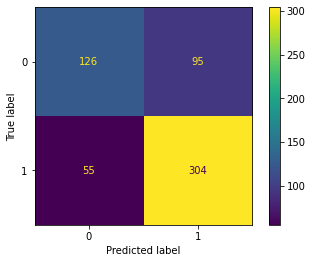

In [ ]:
#Plot th confusion matrix of CNN 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
prediction_= CNN.predict(test_X)
pred_Y=np.argmax(prediction_, axis=1)
test_Y=np.argmax(test_Y, axis=1)
cm = confusion_matrix(test_Y, pred_Y)

cm_display = ConfusionMatrixDisplay(cm).plot()

In [ ]:
print('The accuracy of LSTM in test set is {}%'.format(round(lstm_accuracy*100,2)))
LSTM_cm

The accuracy of LSTM in test set is 74.14%


,Predict_Neg,Predict_Pos
Real_Neg,131,90
Real_Pos,60,299


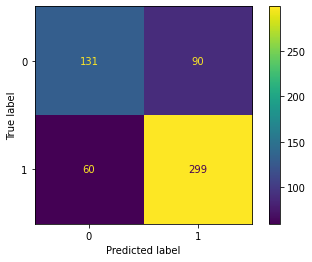

In [ ]:
#Plot th confusion matrix of LSTM 
prediction_= LSTM_.predict(test_X)
pred_Y=np.argmax(prediction_, axis=1)
cm = confusion_matrix(test_Y, pred_Y)
cm_display = ConfusionMatrixDisplay(cm).plot()

In both models we found a better results for predicting positive sentiment, this probably due the fact that in our sample we have more tweets with positive sentiment, so the model is trained mostly with positive, producing a better score with positive tweets and less efficient with the negative ones. 

# Task #4 : Sentment analysis - Optional

In [ ]:
# Use transformers (BERT from Huggingface) to perform another sentiment analysis and compare to the sentiment value in the data
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 17.6 MB/s 
     |████████████████████████████████| 6.6 MB 64.2 MB/s 
     |████████████████████████████████| 163 kB 47.9 MB/s 


In [ ]:
# Build the model for BERT to perform the sentiment analysis
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_41 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
# Split the dataset in train and test parts
Train, Test = train_test_split(data, random_state=0, train_size = .90)

In [ ]:
del Train["Text"]

In [ ]:
# Train dataset
Train=Train[['Text_clean','Sentiment']]
Train.columns = ['DATA_COLUMN', 'LABEL_COLUMN']
Train

,DATA_COLUMN,LABEL_COLUMN
5766,coronavirus global stock plunge donald trump a...,0
1657,user opportunity buy imho bac monday premarket,1
4720,gid reach tgt nxt,1
4950,judge past yrs expect snuck tonight monday jos...,0
5474,peoples bank china acquire stake hdfc amid mar...,1
...,...,...
2765,breakout imminent,1
2461,gmc upside volume low confirm strong support b...,1
1768,qqq breaking base pattern today expect goog hi...,1
4293,aap take profit sunshine repeat,0


In [ ]:
del Test["Text"]

In [ ]:
# Test dataset
Test=Test[['Text_clean', 'Sentiment']]
Test.columns = ['DATA_COLUMN', 'LABEL_COLUMN']
Test

,DATA_COLUMN,LABEL_COLUMN
2962,gd abx fcx ngt gold ebound per euro progress a...,1
904,swy drink safeway store brand columbian whole ...,1
3493,acad try move,1
666,aap short cover blow system would route nyseac...,0
4866,goog leader move first index follow way around,0
...,...,...
4843,continue work well big breakout retest followt...,1
2451,coh low,0
5671,sensex plunge point nifty hit coronavirusle lo...,0
1500,weird action seem like artificially stuck,0


In [ ]:
### Creating input sequence in order to convert the dataset into a suitable format for the BERT model
# We have two pandas Dataframe objects waiting for us to convert them into suitable objects for the BERT model. 
# We will take advantage of the InputExample function that helps us to create sequences from our dataset. 
# The InputExample function can be called as follows:
InputExample(guid=None,
             text_a = "Hello, world",
             text_b = None,
             label = 1)

InputExample(guid=None, text_a='Hello, world', text_b=None, label=1)

In [ ]:
# Now we will create two main functions:
# 1 — convert_data_to_examples: This will accept our train and test datasets and convert each row into an InputExample object.
# 2 — convert_examples_to_tf_dataset: This function will tokenize the InputExample objects, then create the required input format with the tokenized objects, finally, create an input dataset that we can feed to the model.
def convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN): 
  train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

  test_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)
  
  return train_InputExamples, test_InputExamples

  train_InputExamples, test_InputExamples = convert_data_to_examples(train, 
                                                                           test, 
                                                                           'DATA_COLUMN', 
                                                                           'LABEL_COLUMN')

def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] 

    for e in examples:
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )
    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )
    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )


DATA_COLUMN = 'DATA_COLUMN'
LABEL_COLUMN = 'LABEL_COLUMN'


In [ ]:
# Here we convert the dataset into a suitable format for the BERT model
train_InputExamples, test_InputExamples = convert_data_to_examples(Train, Test, DATA_COLUMN, LABEL_COLUMN)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(32).repeat(2)

validation_data = convert_examples_to_tf_dataset(list(test_InputExamples), tokenizer)
validation_data = validation_data.batch(32)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2308: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# Fit the model of BERT
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

model.fit(train_data, epochs=5, steps_per_epoch=20)

Epoch 1/5
20/20 [==============================] - 37s 782ms/step - loss: 0.6849 - accuracy: 0.5781
Epoch 2/5
20/20 [==============================] - 16s 811ms/step - loss: 0.6743 - accuracy: 0.6172
Epoch 3/5
20/20 [==============================] - 16s 803ms/step - loss: 0.6472 - accuracy: 0.6438
Epoch 4/5
20/20 [==============================] - 16s 802ms/step - loss: 0.6410 - accuracy: 0.6438
Epoch 5/5
20/20 [==============================] - 16s 784ms/step - loss: 0.5362 - accuracy: 0.7547


In [ ]:
# Fit the model and predict the test data, computing the test accuracy
bert_loss, bert_accuracy = model.evaluate(validation_data,
                                batch_size=batch_size,
                                verbose=False)

print("\nTesting Accuracy:  {:.4f}".format(bert_accuracy))


Testing Accuracy:  0.7586


Comment: the performance of the algorithm on financial tweets is around 0.75 and model's accuracy on the testing data is lower than the training or validation accuracy, it usually indicates that there are meaningful differences between the kind of data you trained the model on and the testing data you're providing for evaluation.
Compared to the original classification where we had an accuracy rate of 0.7414, with BERT the accuracy rate is similar always around 0.75.


## Task #5 : Measuring media attention

In [ ]:
#all stocks 
tickers = ['MMM','ABT','ABBV','ABMD','ACN','ATVI','ADBE','AMD','AAP','AES','AFL','A','APD','AKAM','ALK','ALB','ARE','ALGN','ALLE','LNT','ALL','GOOGL','GOOG','MO','AMZN','AMCR','AEE','AAL','AEP','AXP','AIG','AMT','AWK','AMP','ABC','AME','AMGN','APH','ADI','ANSS','ANTM','AON','AOS','APA','AAPL','AMAT','APTV','ADM','ANET','AJG','AIZ','T','ATO','ADSK','ADP','AZO','AVB','AVY','BKR','BLL','BAC','BBWI','BAX','BDX','BRK.B','BBY','BIO','BIIB','BLK','BK','BA','BKNG','BWA','BXP','BSX','BMY','AVGO','BR','BF.B','CHRW','COG','CDNS','CZR','CPB','COF','CAH','KMX','CCL','CARR','CTLT','CAT','CBOE','CBRE','CDW','CE','CNC','CNP','CERN','CF','CRL','SCHW','CHTR','CVX','CMG','CB','CHD','CI','CINF','CTAS','CSCO','C','CEGVV','CFG','CTXS','CLX','CME','CMS','KO','CTSH','CL','CMCSA','CMA','CAG','COP','ED','STZ','COO','CPRT','GLW','CTVA','COST','CCI','CSX','CMI','CVS','DHI','DHR','DRI','DVA','DE','DAL','XRAY','DVN','DXCM','FANG','DLR','DFS','DISCA','DISCK','DISH','DG','DLTR','D','DPZ','DOV','DOW','DTE','DUK','DRE','DD','DXC','EMN','ETN','EBAY','ECL','EIX','EW','EA','EMR','ENPH','ETR','EOG','EFX','EQIX','EQR','ESS','EL','ETSY','EVRG','ES','RE','EXC','EXPE','EXPD','EXR','XOM','FFIV','FB','FAST','FRT','FDX','FIS','FITB','FE','FRC','FISV','FLT','FMC','F','FTNT','FTV','FBHS','FOXA','FOX','BEN','FCX','GRMN','IT','GNRC','GD','GE','GIS','GM','GPC','GILD','GL','GPN','GS','GWW','HAL','HBI','HIG','HAS','HCA','PEAK','HSIC','HSY','HES','HPE','HLT','HOLX','HD','HON','HRL','HST','HWM','HPQ','HUM','HBAN','HII','IEX','IDXX','INFO','ITW','ILMN','INCY','IR','INTC','ICE','IBM','IP','IPG','IFF','INTU','ISRG','IVZ','IPGP','IQV','IRM','JKHY','J','JBHT','SJM','JNJ','JCI','JPM','JNPR','KSU','K','KEY','KEYS','KMB','KIM','KMI','KLAC','KHC','KR','LHX','LH','LRCX','LW','LVS','LEG','LDOS','LEN','LLY','LNC','LIN','LYV','LKQ','LMT','L','LOW','LUMN','LYB','MTB','MRO','MPC','MKTX','MAR','MMC','MLM','MAS','MA','MKC','MCD','MCK','MDT','MRK','MET','MTD','MGM','MCHP','MU','MSFT','MAA','MRNA','MHK','TAP','MDLZ','MPWR','MNST','MCO','MS','MOS','MSI','MSCI','NDAQ','NTAP','NFLX','NWL','NEM','NWSA','NWS','NEE','NLSN','NKE','NI','NSC','NTRS','NOC','NLOK','NCLH','NOV','NRG','NUE','NVDA','NVR','NXPI','onsemi','ORLY','OXY','ODFL','OMC','OKE','ORCL','OGN','OTIS','PCAR','PKG','PH','PAYX','PAYC','PYPL','PENN','PNR','PBCT','PEP','PKI','PRGO','PFE','PM','PSX','PNW','PXD','PNC','POOL','PPG','PPL','PFG','PG','PGR','PLD','PRU','PTC','PEG','PSA','PHM','PVH','QRVO','PWR','QCOM','DGX','RL','RJF','RTX','O','REG','REGN','RF','RSG','RMD','RHI','ROK','ROL','ROP','ROST','RCL','SPGI','CRM','SBAC','SLB','STX','SEE','SRE','NOW','SHW','SPG','SWKS','SNA','SO','LUV','SWK','SBUX','STT','STE','SYK','SIVB','SYF','SNPS','SYY','TECH','TMUS','TROW','TTWO','TPR','TGT','TEL','TDY','TFX','TER','TSLA','TXN','TXT','TMO','TJX','TSCO','TT','TDG','TRV','TRMB','TFC','TWTR','TYL','TSN','UDR','ULTA','USB','UAA','UA','UNP','UAL','UNH','UPS','URI','UHS','UNM','VLO','VTR','VRSN','VRSK','VZ','VRTX','VFC','VIAC','VTRS','V','VNO','VMC','WRB','WAB','WMT','WBA','DIS','WM','WAT','WEC','WFC','WELL','WST','WDC','WU','WRK','WY','WHR','WMB','WLTW','WYNN','XEL','XLNX','XYL','YUM','ZBRA','ZBH','ZION','ZTS']

In [ ]:
# Function to put the words of twwet into a set 
def txt2set(text):
    return set(text.split())

data_temp = data[['Text','Sentiment']]
data_temp['Text_set'] = data_temp['Text'].apply(lambda x:txt2set(x))
data_temp

In [ ]:
#Function to compute the media_attention: a dataframe with the total, positive and negative tweets for each stock 
def media_attention(data,tickers):
    result = pd.DataFrame(index=tickers,columns=['total_tweets','positive_num','negative_num'])
    for stock in tickers:
        tot,pos,neg = 0,0,0
        if len(stock)<3: # If the length of the tickers is 1 or 2, then it has to be upper case, or it may be confused with parts of regular words
            for sentence,sentiment in zip(data['Text_set'],data['Sentiment']):
                if stock in sentence:
                    tot += 1
                    if sentiment==1:
                        pos += 1
                    else:
                        neg += 1
        else: # If the length is 3 and over, the lower case is allowed because the possibility of confusion is low
            for sentence,sentiment in zip(data['Text_set'],data['Sentiment']):
                if (stock in sentence) or (stock.lower() in sentence):
                    tot += 1
                    if sentiment==1:
                        pos += 1
                    else:
                        neg += 1            

            
        result.loc[stock,'total_tweets'] = tot
        result.loc[stock,'positive_num'] = pos
        result.loc[stock,'negative_num'] = neg
    return result
media_attention_df = media_attention(data_temp,tickers)
media_attention_df

In [ ]:
media_attention_df['total_tweets'].sum() # There are in total 4274 tweets that mentioned the tickers

In [ ]:
# Sorted by total tweets number to visualize the stocks with the highest mentions
media_attention_df.sort_values(by='total_tweets',ascending=False)

In [ ]:
# Sorted by positive tweets number
media_attention_df.sort_values(by='positive_num',ascending=False)


In [ ]:
# Sorted by negative tweets number
media_attention_df.sort_values(by='negative_num',ascending=False)

In [ ]:
upload_2=files.upload()

In [ ]:
# Compute the average return of the stocks 
data_price = pd.read_csv('Data_PCLab1_Stock.csv')
data_price['Date'] = pd.to_datetime(data_price['Date'])
data_price = data_price.sort_values('Date') #sort the data by date
def daily_return(data):
    prices = data.iloc[:,1:].reset_index()
    p1 = prices.iloc[1:,:].reset_index().drop(['level_0','index'],axis=1)
    p0 = prices.iloc[:-1,:].reset_index().drop(['level_0','index'],axis=1)
    p1_p0 = p1-p0
    returns = p1_p0/p0
    returns['Date'] = data['Date'][:-1].reset_index().drop(['index'],axis=1)
    date = returns.pop('Date')
    returns.insert(0,'Date',date)
    return returns
avg_y_r = daily_return(data_price).mean()*252
avg_y_r

In [ ]:
# extract the number of total, positive and negative tweets of the 8 stocks
stocks_names = list(avg_y_r.index)[:-1]
tot_t = media_attention_df.loc[stocks_names,'total_tweets']
pos_t = media_attention_df.loc[stocks_names,'positive_num']
neg_t = media_attention_df.loc[stocks_names,'negative_num']

In [ ]:
from scipy import stats

In [ ]:
# Run a linear regression to see if we have a correlation between media attention and excess return 
tweet_return = pd.DataFrame(index=['total tweets','positive tweets','negative tweets'],columns=['slope','pvalue','significant'])

totres = stats.linregress(tot_t.tolist(),avg_y_r[:-1].tolist())
tweet_return.loc['total tweets','slope'] = totres[0]
tweet_return.loc['total tweets','pvalue'] = totres[3]
tweet_return.loc['total tweets','significant'] = (totres[3]<=0.05)

posres = stats.linregress(pos_t.tolist(),avg_y_r[:-1].tolist())
tweet_return.loc['positive tweets','slope'] = posres[0]
tweet_return.loc['positive tweets','pvalue'] = posres[3]
tweet_return.loc['positive tweets','significant'] = (posres[3]<=0.05)

negres = stats.linregress(neg_t.tolist(),avg_y_r[:-1].tolist())
tweet_return.loc['negative tweets','slope'] = negres[0]
tweet_return.loc['negative tweets','pvalue'] = negres[3]
tweet_return.loc['negative tweets','significant'] = (negres[3]<=0.05)

tweet_return

The slopes of the linear regressions are positive(≈0), but all not significant 

In [ ]:
#Plot to see if there is a correlation  between media attention and excess return 
fig= plt.figure(figsize=(7,7))
plt.scatter(tot_t,avg_y_r[:-1],label='total tweets amount')
plt.scatter(pos_t,avg_y_r[:-1],label='Positive tweets amount')
plt.scatter(neg_t,avg_y_r[:-1],label='Negative tweets amount')
plt.xlabel('tweets amount')
plt.ylabel('excess returns')
plt.title('Excess return vs Negative tweets amount',fontdict={'fontsize':15},pad=15)
lims = [np.min([plt.xlim(), plt.ylim()]),np.max([plt.xlim(), plt.ylim()])]  # min of both axes # max of both axes
plt.plot(lims[0], lims[1], 'k-', alpha=0.75, zorder=0, scalex=False, scaley=False)
#plt.aspect('equal')
plt.xlim(lims)
#plt.ylim(lims)

# now plot both limits against eachother
plt.legend()
plt.show()

The tweets amount (total, positive, negative) seems positively correlated to the returns but none of them are significant.
Actually, the sample size is far from enough to get an unbiased result.
One of the feasible way is that: We regress the daily return of a stock to the tweets about this stock in the corresponding days (the data can be daily or monthly or other types and it also can be lagged instead of corresponding). So we could have better results if we have daily or monthly tweets, in this way we expect a more higher correlation and less biased results. 